# ***Anomaly Prediction***

This notebook builds a binary classification model to detect rare events from sensor data. The dataset is highly imbalanced, and the pipeline includes preprocessing, training multiple models, evaluation, and generating predictions for submission.

# Library Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, f1_score

# Data Loading

In [2]:

# Load data
train = pd.read_parquet('/data/train.parquet')
test = pd.read_parquet('/data/test.parquet')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("\nTrain head:")
print(train.head())
print("\nTest head:")
print(test.head())

Train shape: (1639424, 7)
Test shape: (409856, 7)

Train head:
        Date        X1        X2   X3        X4        X5 target
0 2020-12-16  1.518921  5.463154  1.0  2.718282  2.890372      0
1 2020-12-16  1.546509  5.458010  1.0  2.718282  2.833213      1
2 2020-12-16  1.645427  5.456560  1.0  7.389056  2.890372      1
3 2020-12-16  1.652022  5.458479  1.0  2.718282  2.890372      1
4 2020-12-16  1.695538  5.466709  1.0  2.718282  2.890372      0

Test head:
   ID       Date        X1        X2   X3        X4        X5
0   0 2020-12-16  1.685395  5.463917  1.0  7.389056  2.890372
1   1 2020-12-16  1.488844  5.454936  1.0  7.389056  2.890372
2   2 2020-12-16  1.164160  5.471136  1.0  1.000000  2.890372
3   3 2020-12-16  1.000000  5.467385  1.0  1.000000  2.890372
4   4 2020-12-16  1.000000  5.453995  1.0  1.000000  2.833213


In [3]:
# Create time features
def create_time_features(df):
    df['hour'] = df['Date'].dt.hour
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['day_of_month'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

train = create_time_features(train)
test = create_time_features(test)

# Sensor columns
sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']
time_features = ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend']

In [4]:
# Winsorization
def handle_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

train = handle_outliers(train, sensor_cols)
test = handle_outliers(test, sensor_cols)


# Preprocessing

In [5]:

# Scaling
scaler = StandardScaler()
train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

# Class balance
target_dist = train['target'].value_counts(normalize=True)
print("\nTarget distribution:")
print(target_dist)


Target distribution:
target
0    0.991437
1    0.008563
Name: proportion, dtype: float64


In [6]:
# Convert str to int
train['target'] = train['target'].astype(int)

# Prepare data
X = train[sensor_cols + time_features]
y = train['target']
X_test = test[sensor_cols + time_features]

# validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

#  XGBoost
xgb = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=target_dist[0] / target_dist[1],
    random_state=42
)
xgb.fit(X_train, y_train)

#  LightGBM
lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)
lgbm.fit(X_train, y_train)


/tmp/ipykernel_19/1734452286.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight=target_dist[0] / target_dist[1],


[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, random_state=42)

# Model Evaluation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


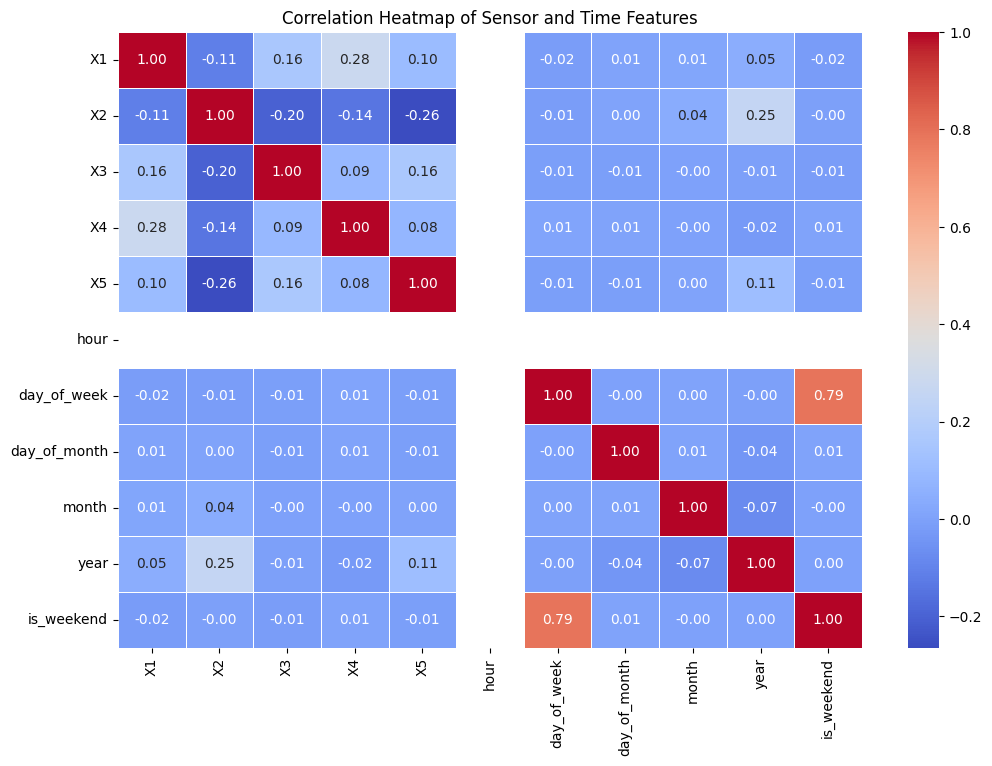

In [7]:
corr_matrix = train[sensor_cols + time_features].corr()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Sensor and Time Features")
plt.show()


RandomForestClassifier Performance:
Accuracy: 0.9810055354773778
F1 Score: 0.43780465788048384

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    325077
           1       0.29      0.86      0.44      2808

    accuracy                           0.98    327885
   macro avg       0.65      0.92      0.71    327885
weighted avg       0.99      0.98      0.99    327885



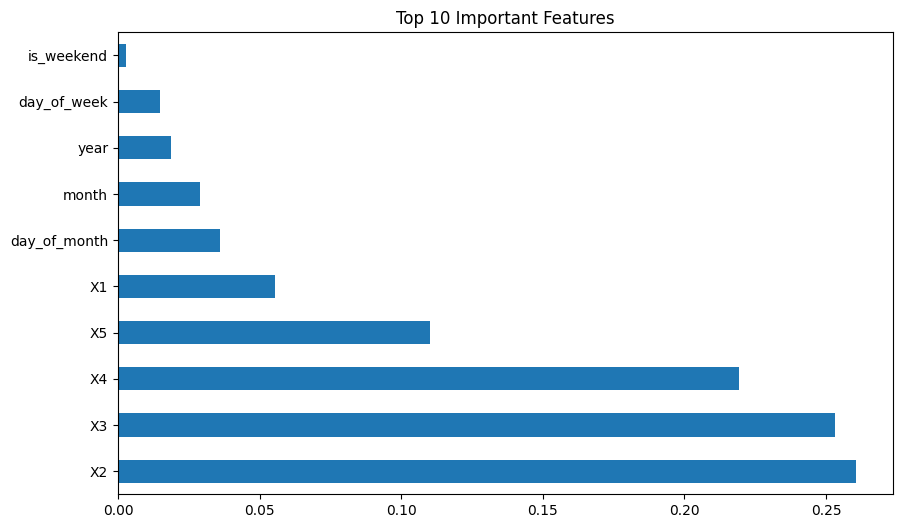


XGBClassifier Performance:
Accuracy: 0.9515134879607179
F1 Score: 0.24981124952812384

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    325077
           1       0.14      0.94      0.25      2808

    accuracy                           0.95    327885
   macro avg       0.57      0.95      0.61    327885
weighted avg       0.99      0.95      0.97    327885



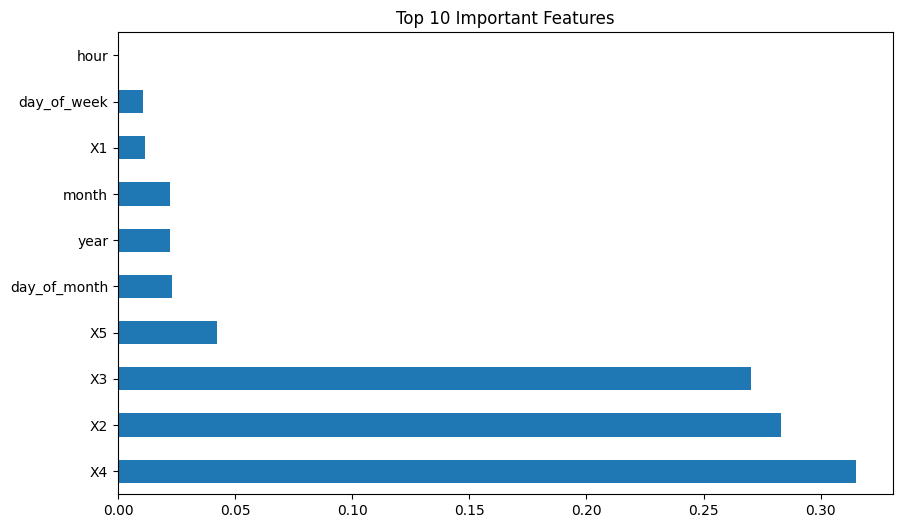


LGBMClassifier Performance:
Accuracy: 0.9436570748890617
F1 Score: 0.22358577792720855

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    325077
           1       0.13      0.95      0.22      2808

    accuracy                           0.94    327885
   macro avg       0.56      0.95      0.60    327885
weighted avg       0.99      0.94      0.96    327885



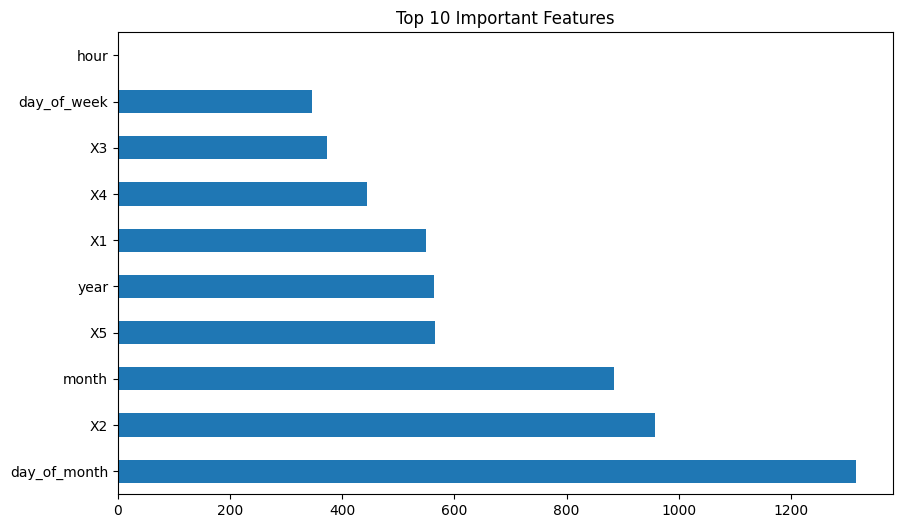

In [8]:
# Evaluate models
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"\n{model.__class__.__name__} Performance:")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("F1 Score:", f1_score(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.title('Top 10 Important Features')
        plt.show()

evaluate_model(rf, X_val, y_val)
evaluate_model(xgb, X_val, y_val)
evaluate_model(lgbm, X_val, y_val)


In [9]:
def evaluate_thresholds(model, X_val, y_val):
    y_probs = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold = thresholds[f1_scores.argmax()]
    best_f1 = f1_scores.max()
    return best_threshold, best_f1

In [10]:
#Checking for best threshold
# Evaluate RandomForestClassifier
rf_threshold, rf_best_f1 = evaluate_thresholds(rf, X_val, y_val)
print(f"Optimal threshold for RandomForestClassifier: {rf_threshold} with F1 score: {rf_best_f1}")

# Evaluate XGBClassifier
xgb_threshold, xgb_best_f1 = evaluate_thresholds(xgb, X_val, y_val)
print(f"Optimal threshold for XGBClassifier: {xgb_threshold} with F1 score: {xgb_best_f1}")

# Evaluate LGBMClassifier
lgbm_threshold, lgbm_best_f1 = evaluate_thresholds(lgbm, X_val, y_val)
print(f"Optimal threshold for LGBMClassifier: {lgbm_threshold} with F1 score: {lgbm_best_f1}")

Optimal threshold for RandomForestClassifier: 0.8437341465233582 with F1 score: 0.6081958093825328
Optimal threshold for XGBClassifier: 0.9633550643920898 with F1 score: 0.5742124066255277
Optimal threshold for LGBMClassifier: 0.9670819087045095 with F1 score: 0.5476150627615063


In [11]:

# Assuming 'model' is your trained classifier and 'X_val' is your validation set
# Predict probabilities for the positive class
y_probs = rf.predict_proba(X_val)[:, 1]

# Define a range of thresholds to evaluate
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

# Evaluate F1 score for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    score = f1_score(y_val, y_pred)
    f1_scores.append(score)

# Find the threshold that gives the maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal threshold: {optimal_threshold} with F1 score: {optimal_f1}")

Optimal threshold: 0.84 with F1 score: 0.6071494042163154


# Final Submission

In [12]:
# Based on validation performance, select the best model
final_threshold = rf_threshold  # Ramdom forest = best performance

# Apply the final threshold to the test set
test_probs = rf.predict_proba(X_test)[:, 1]
test_predictions = (test_probs >= final_threshold).astype(int)

# Create submission file
submission = pd.DataFrame({
    'ID': test.index,
    'target': test_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)
submission.to_parquet('sample_submission.parquet', index=False)

print("\nSubmission file saved .")



Submission file saved .
